In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets
import edhec_risk_kit as erk
import matplotlib as mpl
from numba import njit
import pandas as pd
import numpy as np

#mpl.rcParams['figure.dpi'] = 100
#mpl.rcParams['figure.figsize'] = (9, 4)
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False


## GBM Interactive Plots

<AxesSubplot:>

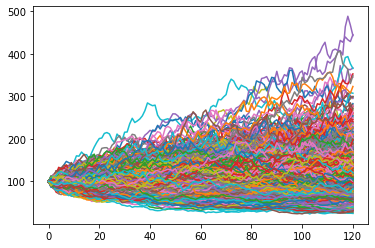

In [2]:
erk.gbm(10,1000, mu = 0.01).plot(legend = False)

In [3]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    s_0 = 100
    prices = erk.gbm(n_scenarios = n_scenarios, mu = mu, sigma = sigma , s_0 = s_0)
    ax = prices.plot(legend = False, color = 'indianred', alpha = 0.10, linewidth = 2, figsize = (12,5))
    ax.axhline(y = s_0, ls =":",color = 'black')
    
    ax.plot(0,s_0, marker = 'o', color = 'darkred', alpha = 1)

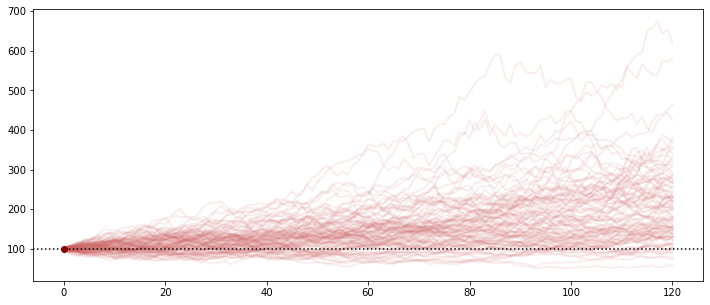

In [4]:
show_gbm(100,0.07,0.15)

In [5]:
gbm_controls = widgets.interactive(show_gbm,
                                   n_scenarios = (100,500,100),
                                   mu = (-0.1,0.2,0.01),
                                   sigma = (0,0.4,0.01)
                                  )

In [6]:
display(gbm_controls)

interactive(children=(IntSlider(value=300, description='n_scenarios', max=500, min=100, step=100), FloatSlider…

## Interactive CPPI Simulation - Monte Carlo

In [7]:
def show_cppi(n_scenarios = 100, mu =0.07, sigma = 0.15, m = 3, floor = 0, riskfree_rate = 0.01, y_max = 100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year = 12)
    risky_r = pd.DataFrame(sim_rets)
    
    # Run the backtest
    btr = erk.run_cppi(risky_r = pd.DataFrame(risky_r), riskfree_rate = riskfree_rate, m = m, start = start, floor = floor)
    wealth = btr["Wealth"]
    y_max = wealth.values.max()*y_max/100
    ax = wealth.plot(legend = False, alpha = 0.3, color = 'indianred', figsize = (12,6))
    ax.axhline(y=start, ls = ":", color = "black")
    ax.axhline(y=start*floor, ls = "--", color = "red")
    ax.set_ylim(top = y_max)
    
    


In [8]:
cppi_controls = widgets.interactive(show_cppi,
                                   n_scenarios = widgets.IntSlider(min = 100, max =500, step =100, value = 50),
                                   mu = (-0.05,0.2,0.01),
                                   sigma = (0,0.4,0.01),
                                   floor = (0,2,0.1),
                                   m = (1,5,0.5),
                                   riskfree_rate = (0,0.05,0.01),
                                   y_max = widgets.IntSlider(min=0, max=100, step=1, value = 100, description = "Zoom Y Axis")
                                        
                                  )

cppi_controls

interactive(children=(IntSlider(value=100, description='n_scenarios', max=500, min=100, step=100), FloatSlider…

## Improving our Interactions with Violation Histograms

In [9]:
def show_cppi(n_scenarios = 100, mu =0.07, sigma = 0.15, m = 3, floor = 0, riskfree_rate = 0.01, steps_per_year = 12, y_max = 100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year = steps_per_year)
    risky_r = pd.DataFrame(sim_rets)
    
    # Run the algorithm on generated brownian motion
    btr = erk.run_cppi(risky_r = pd.DataFrame(risky_r), riskfree_rate = riskfree_rate, m = m, start = start, floor = floor)
    wealth = btr["Wealth"]
    y_max = wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    
    # Compute statistics
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start * floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios
    
    # When there is a failure, what is the average failure extent?
    e_shortfall = np.dot(terminal_wealth - start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0
    
    
    
    # Plot
    
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey = True, gridspec_kw = {'width_ratios':[3,2]}, figsize = (15,8))
    plt.subplots_adjust(wspace = 0.0)
    
    wealth_ax = wealth.plot(ax = wealth_ax, legend = False, alpha = 0.3, color = 'indianred')
    wealth_ax.axhline(y=start, ls = ":", color = "black")
    wealth_ax.axhline(y=start*floor, ls = "--", color = "red")

    
    terminal_wealth.plot.hist(ax = hist_ax, bins = 50, ec='w', fc = 'indianred', orientation = 'horizontal')
    hist_ax.axhline(y=tw_mean, ls=":", color = 'blue')
    hist_ax.axhline(y=tw_median, ls=":", color = 'purple')
    hist_ax.annotate(f"Mean: ${tw_mean:2.2f}", xy = (0.55,0.9),xycoords = 'axes fraction', fontsize = 14)
    hist_ax.annotate(f"Median: ${tw_median:2.2f}", xy = (0.55,0.85),xycoords = 'axes fraction', fontsize = 14)
    
    if floor > 0.01:
        hist_ax.axhline(y=start*floor, ls = '--', color = 'red', linewidth = 3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy = (0.55,0.75),xycoords = 'axes fraction', fontsize = 14)
    
    
    



In [32]:
cppi_controls = widgets.interactive(show_cppi,
                                   n_scenarios = widgets.IntSlider(min = 100, max =500, step =100, value = 50),
                                   mu = (-0.05,0.25,0.01),
                                   sigma = (0,0.5,0.01),
                                   floor = (0,1,0.05),
                                   m = (1,3,0.1),
                                   riskfree_rate = (-0.02,0.05,0.01),
                                   steps_per_year = widgets.IntSlider(min=1,max=24, step = 1, value = 1, description = "Rebals/Year"),
                                   y_max = widgets.IntSlider(min=0, max=100, step=1, value = 100, description = "Zoom Y Axis")
                                        
                                  )

cppi_controls

interactive(children=(IntSlider(value=100, description='n_scenarios', max=500, min=100, step=100), FloatSlider…

In [36]:
hsu = pd.read_csv("HSU.TO.csv", index_col='Date', parse_dates=True)
#hsu.index = hsu['Date']
hsu = hsu['Close'].pct_change().dropna()
annualized_ret = erk.annualize_rets(hsu,12)
annualized_vol = erk.annualize_vol(hsu,12)
hsu
#annualized_ret
#annualized_vol

Date
2009-01-01   -0.172652
2009-02-01   -0.213689
2009-03-01    0.135881
2009-04-01    0.185047
2009-05-01    0.110410
2009-06-01   -0.009943
2009-07-01    0.144907
2009-08-01    0.067669
2009-09-01    0.066901
2009-10-01   -0.045105
2009-11-01    0.119816
2009-12-01    0.031893
2010-01-01   -0.075773
2010-02-01    0.062567
2010-03-01    0.117766
2010-04-01    0.024523
2010-05-01   -0.160461
2010-06-01   -0.122492
2010-07-01    0.137184
2010-08-01   -0.095238
2010-09-01    0.178947
2010-10-01    0.076389
2010-11-01   -0.005530
2010-12-01    0.136237
2011-01-01    0.042414
2011-02-01    0.068075
2011-03-01   -0.003663
2011-04-01    0.055147
2011-05-01   -0.025784
2011-06-01   -0.038627
                ...   
2018-12-01   -0.183906
2019-01-01    0.162093
2019-02-01    0.057034
2019-03-01    0.031427
2019-04-01    0.079295
2019-05-01   -0.129932
2019-06-01    0.139562
2019-07-01    0.024014
2019-08-01   -0.042044
2019-09-01    0.035146
2019-10-01    0.036318
2019-11-01    0.072535
2019-1